[Titanic Top 4% with ensemble modeling](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)

# 1. Introduction

This is my first kernel in Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then will focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

This scripts follows three main parts:
- **Feature analysis**
- **Feature engineering**
- **Modeling**

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set(style="white", context="notebook", palette="deep")

# 2. Load and check data

## 2.1 Load data

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
IDtest = test["PassengerId"]

## 2.2 Outlier detection

In [3]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing morethan n outliers according to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[
            (df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)
        ].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers


# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

Since outliers can have a dramatic effect on the prediction(especially for regression problems), i choosed to manage them.

I used the Tukey method(Tukey JW., 1977) to detect outliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values(IQR). An outliers is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features(Age, SibSp, Parch and Fare). Then, I considered outliers as rows that have at least two outlied numerical values.

#### Tukey Method

**Tukey Method**는 John Tukey가 제안한 이상치(outlier) 탐지 방법으로, **사분위수**(quartiles)를 이용한 간단한 이상치 탐지 기법입니다.

##### 핵심 개념
- **Q1 (제 1 사분위수)**: 하위 25%에 해당하는 값
- **Q3 (제 3 사분위수)**: 상위 25%에 해당하는 값
- **IQR (Interquartile Range)**: 중간 50%의 범위, \( IQR = Q3 - Q1 \)

##### 이상치 탐지 기준
- **일반적인 이상치**: 
  - 하위 경계: \( Q1 - 1.5 \times IQR \)
  - 상위 경계: \( Q3 + 1.5 \times IQR \)
- **극단적인 이상치**:
  - 하위 경계: \( Q1 - 3 \times IQR \)
  - 상위 경계: \( Q3 + 3 \times IQR \)

##### 절차
1. 데이터 정렬
2. **Q1**, **Q3** 계산 및 **IQR** 산출
3. 경계를 계산하여 벗어난 값은 이상치로 간주

##### 장점
- **간단하고 직관적**: 계산이 쉽고 시각적으로 이해하기 용이
- **통계적 가정이 없음**: 데이터 분포에 대한 가정이 없어 다양한 데이터셋에 적용 가능

##### 단점
- **극단적인 분포에 취약**: 비대칭적이거나 극단값이 많은 경우 한계가 있음


In [4]:
train.loc[Outliers_to_drop]  # show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare.
The 7 others have very high values of SibSp.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [6]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

I join train and test datasets to obtain the same number of features during categorical conversion(See feature engineering).

## 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.

**Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and tes set)**

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1 Numerical values

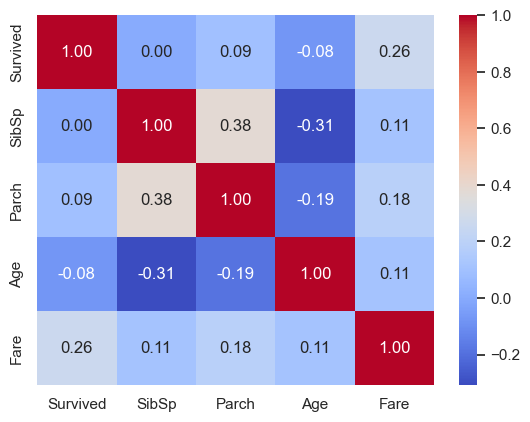

In [12]:
# correlaction matrix between numerical values(SibSp Parch Age and Fare) and Survived
g = sns.heatmap(
    train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
)

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not useful. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

### SibSp

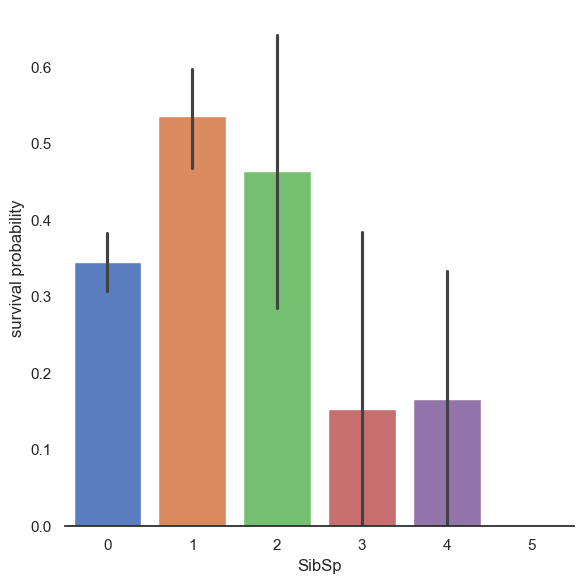

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(
    x="SibSp",
    y="Survived",
    data=train,
    kind="bar",
    height=6,
    hue="SibSp",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive.

Single passengers (0 SibSp) or with two other persons(SibSp 1 or 2) have more chance to survive.

This observations is quite interesting, we can consider a new feature describing these categories(See feature engineering).

### Parch

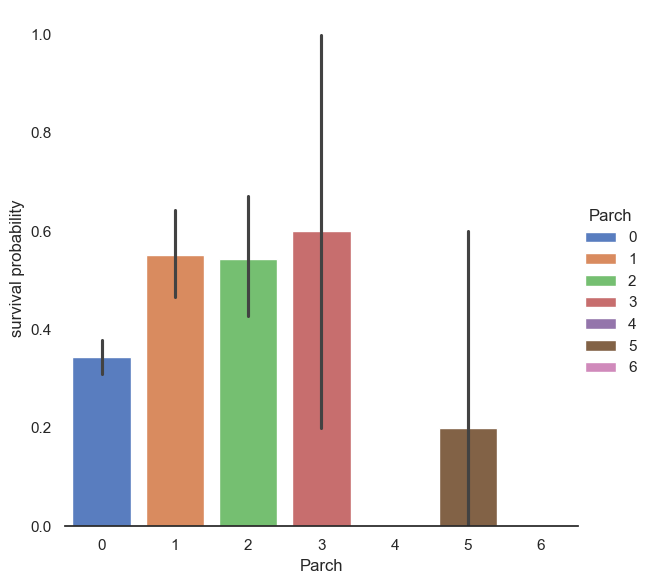

In [14]:
# Explore Parch feature vs Survived
g = sns.catplot(
    data=train,
    x="Parch",
    y="Survived",
    kind="bar",
    height=6,
    hue="Parch",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive. more than single(Parch 0), medium(Parch 3, 4) and large families(Parch 5, 6).

Be careful there is an important standard deviation in the survival of passengers with 3 parents/children.

### Age

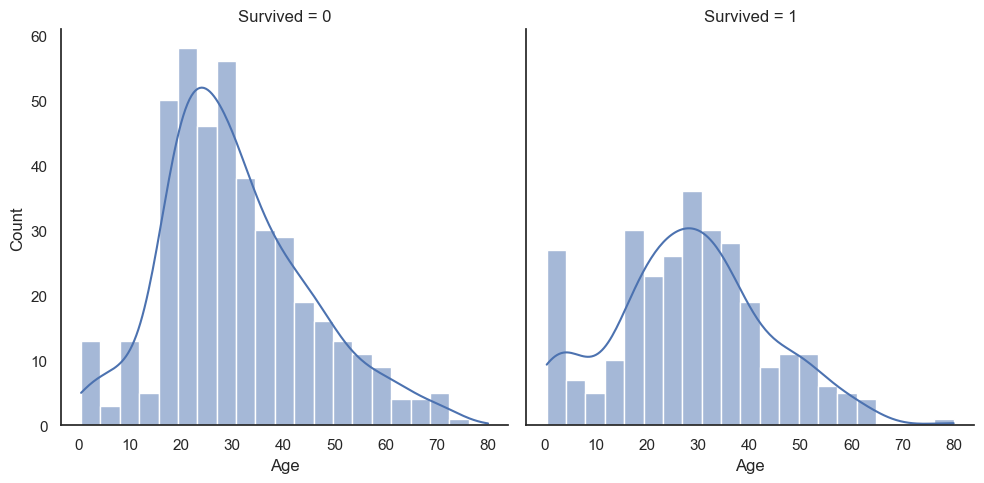

In [15]:
# Explore Age vs Survived

# 데이터의 여러 하위 집합에 대해 여러 그래프를 생성하는 도구
# g = sns.FacetGrid(train, col="Survived")
# 각 subplot에 histplot, Age 열로, 시각화 함수에 kde=True 전달
# g = g.map(sns.histplot, "Age", kde=True)
# g = g.map(sns.kdeplot, 'Age')

# 아래처럼 그냥 displot을 사용해도 된다.
sns.displot(data=train, x="Age", col="Survived", kde=True)

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60~80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

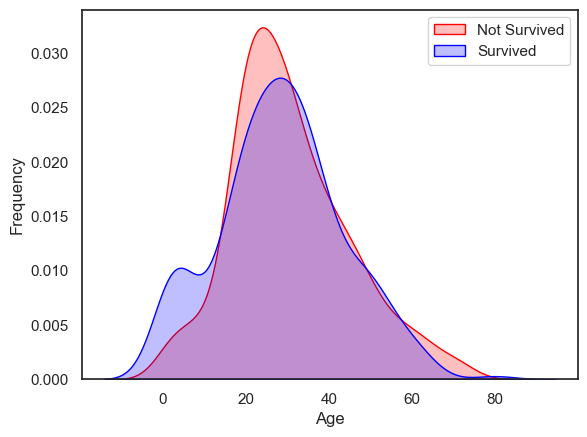

In [16]:
# Explore Age distribution
g = sns.kdeplot(
    data=train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
    color="Red",
    fill=True,
)
g = sns.kdeplot(
    data=train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
    ax=g,
    color="Blue",
    fill=True,
)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

When we superimpose the two densities, we clearly see a peak corresponding(between 0 and 5) to babies and very young childrens.

### Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the prediction.

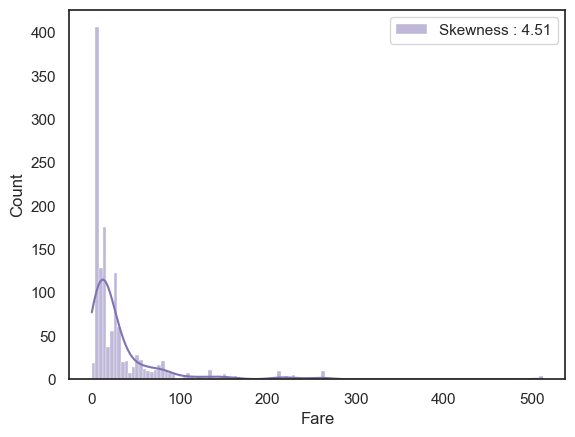

In [19]:
# Explore Fare distribution
g = sns.histplot(
    dataset["Fare"],
    kde=True,
    color="m",
    label="Skewness : %.2f" % (dataset["Fare"].skew()),
)
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

Skewness가 큰 데이터는 모델에서 극단값(outliers)이 모델의 가중치 계산에 과도하게 영향을 줄 수 있습니다. 위 Fare의 경우에 Fare는 대부분 낮은 값들로 구성되지만 일부 높은 값들이 있어 이 값들을 과도하게 중요하게 여기게 될 수 있습니다. 심지어 데이터를 스케일링(정규화)해도 이런 극단값이 영향을 미칠 수 있습니다.

로그 변환은 왜도가 큰 데이터 분포를 더 대칭적인 분포로 변환하는 데 자주 사용됩니다. 높은 값은 작게 변환되고, 작은 값은 비교적 덜 변환되므로 극단값의 영향이 줄어들고, 데이터가 좀 더 균등하게 분포하게 됩니다.

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

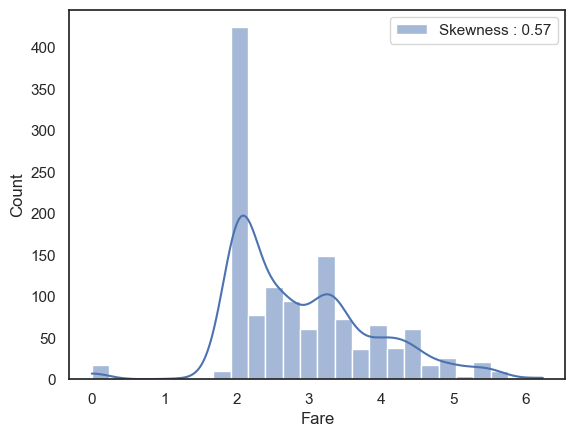

In [21]:
g = sns.histplot(
    data=dataset["Fare"],
    kde=True,
    color="b",
    label="Skewness : %.2f" % (dataset["Fare"].skew()),
)
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation.

## 3.2 Categorical values

### Sex

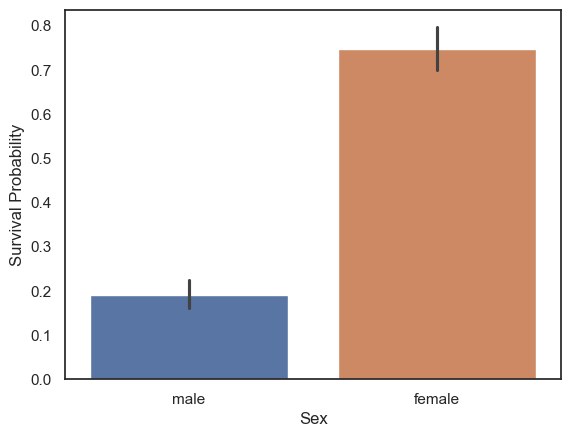

In [22]:
g = sns.barplot(x="Sex", y="Survived", data=train, hue="Sex")
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.

So Sex, might play an important role in the prediction of the survival.

For those who have seen the Titanic movie(1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".

### Pclass

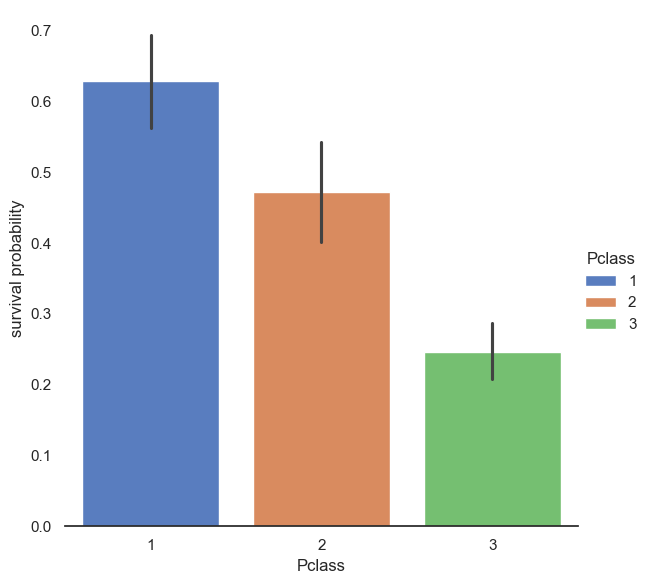

In [24]:
# Explore Pclass vs Survived
g = sns.catplot(
    data=train,
    x="Pclass",
    y="Survived",
    kind="bar",
    height=6,
    hue="Pclass",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("survival probability")

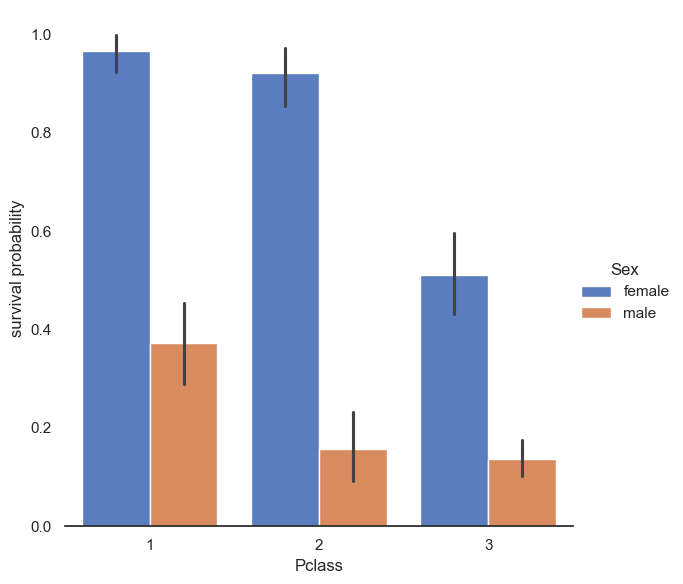

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(
    data=train,
    x="Pclass",
    y="Survived",
    kind="bar",
    height=6,
    hue="Sex",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and thir class passengers.

This trend is conserved when we look at both male and female passengers.

### Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values, I decided to fill them with the most frequent value of "Embarked" (S).

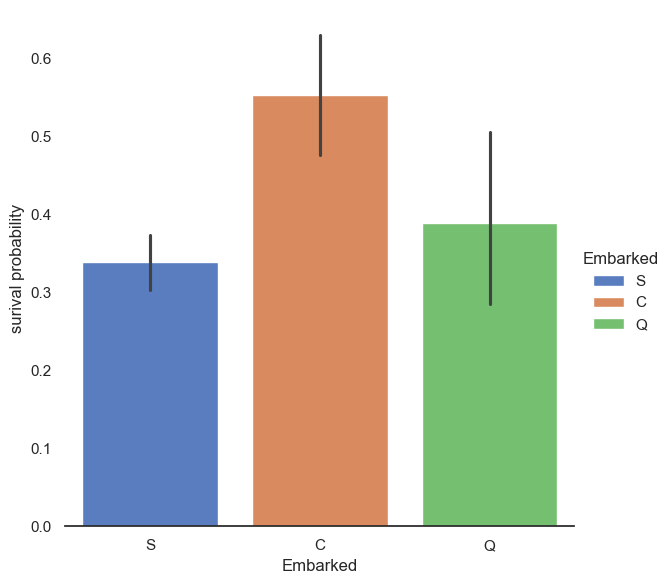

In [28]:
# Explore Embarked vs Survived
g = sns.catplot(
    data=train,
    x="Embarked",
    y="Survived",
    kind="bar",
    height=6,
    hue="Embarked",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("surival probability")

It seems that passenger coming from Cherbourg(C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for thos who came from Cherbourg than Queenstown(Q), Southampton(S)

Let's see the Pclass distribution vs Embarked.

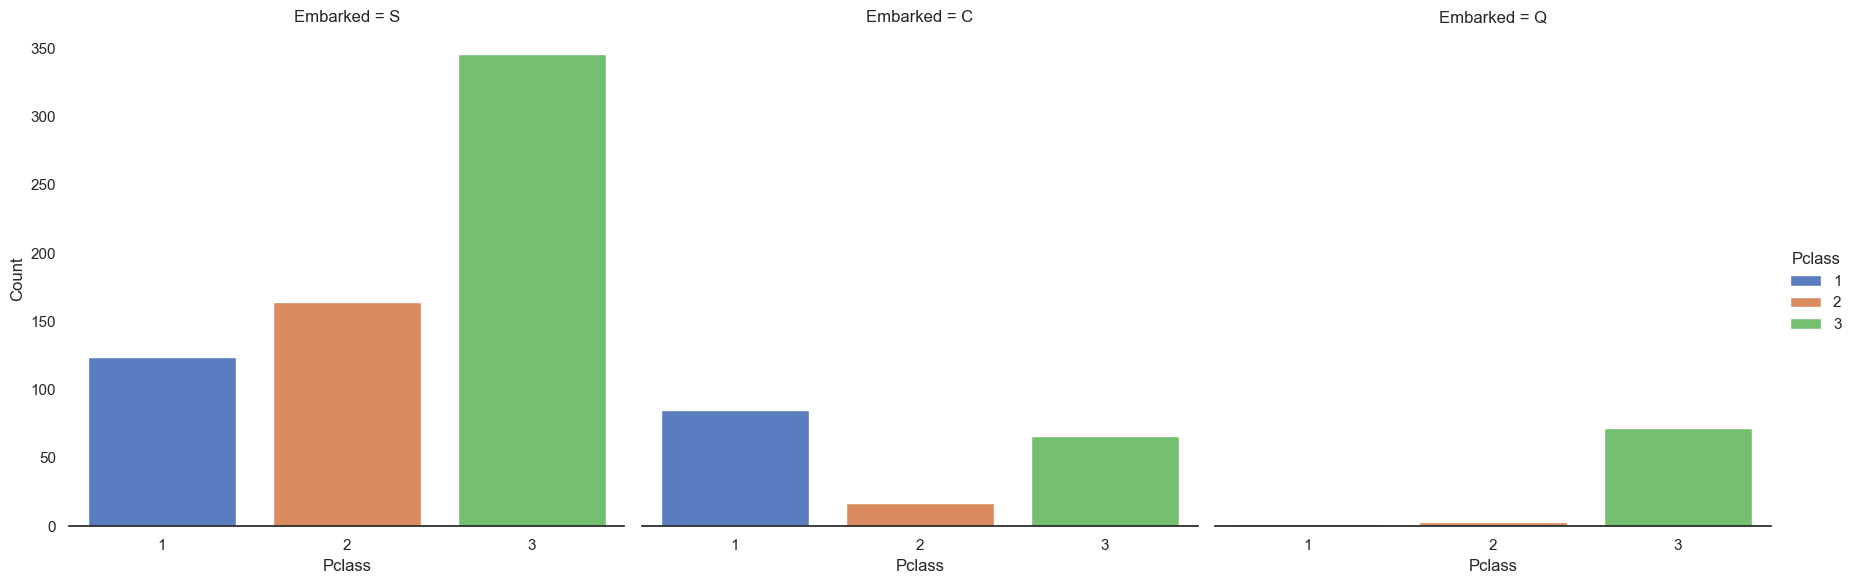

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(
    data=train,
    x="Pclass",
    kind="count",
    col="Embarked",
    height=6,
    hue="Pclass",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from S and Q, where as C passengers are mostly in first class which have the highest survival rate.

At this point, I can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

# 4. Filling missing Values

## 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive(children for example), it is preferable to keep the age feature and to impute the missing values.

To address, this problem, I looked at the most correlated features with Age(Sex, Parch, Pclass and SibSP).

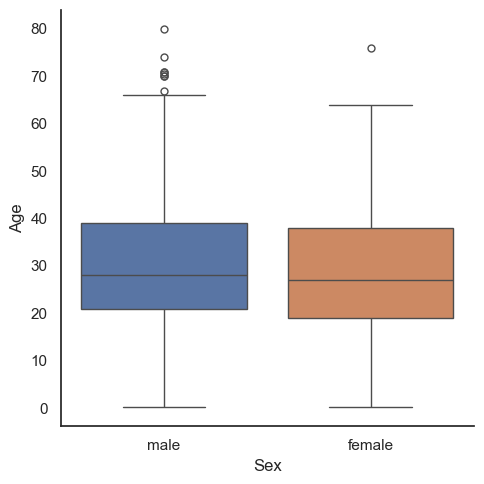

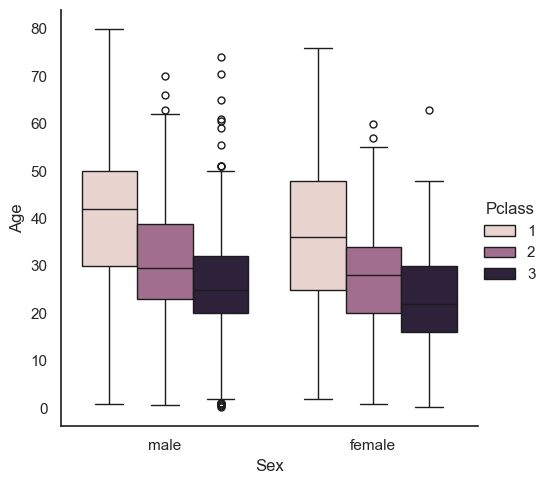

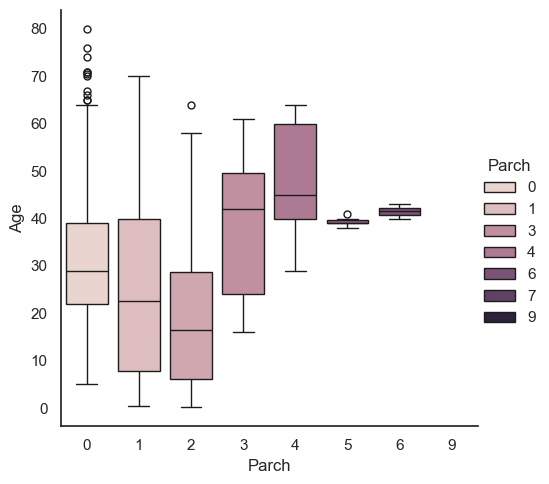

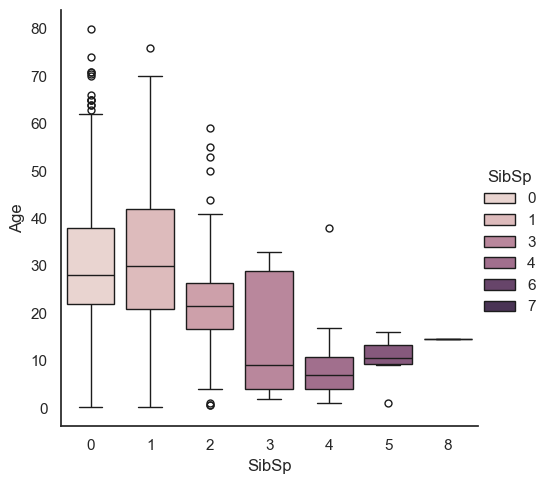

In [32]:
# Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.catplot(data=dataset, x="Sex", y="Age", kind="box", hue="Sex")
g = sns.catplot(data=dataset, x="Sex", y="Age", kind="box", hue="Pclass")
g = sns.catplot(data=dataset, x="Parch", y="Age", kind="box", hue="Parch")
g = sns.catplot(data=dataset, x="SibSp", y="Age", kind="box", hue="SibSp")

Age distribution seems to be the same in Male and Femaile subpopulations, so Sex is not informative to predict Age.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [33]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

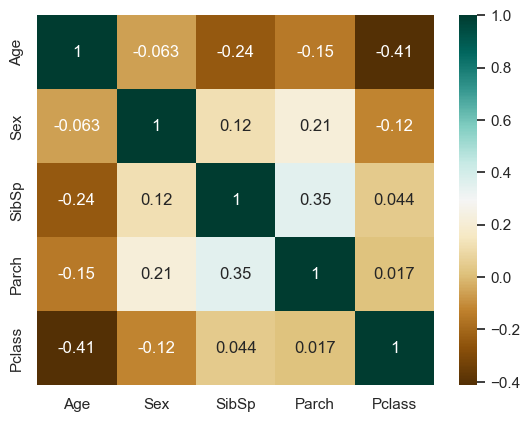

In [34]:
g = sns.heatmap(
    dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True
)

The correlation map confirms that catplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents/children. But the general correlation is negative.

So I decided to use SibSp, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [36]:
# Filling missing value of Age

# Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][
        (
            (dataset["SibSp"] == dataset.iloc[i]["SibSp"])
            & (dataset["Parch"] == dataset.iloc[i]["Parch"])
            & (dataset["Pclass"] == dataset.iloc[i]["Pclass"])
        )
    ].median()

    if not np.isnan(age_pred):
        dataset.loc[i, "Age"] = age_pred
    else:
        dataset.loc[i, "Age"] = age_med

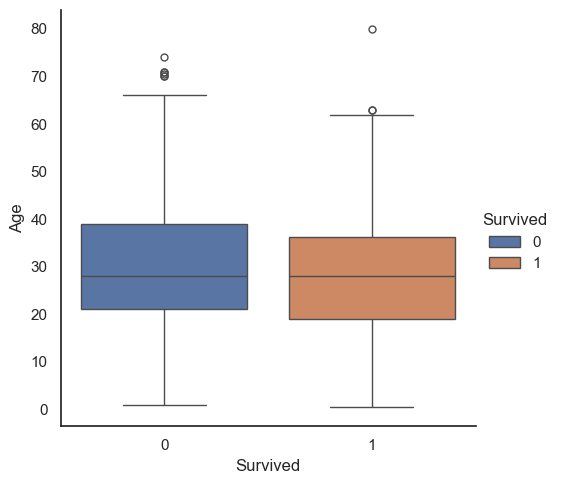

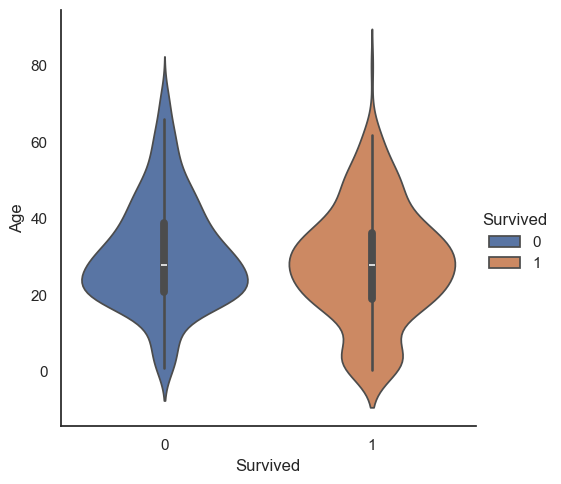

In [38]:
g = sns.catplot(data=train, x="Survived", y="Age", kind="box", hue="Survived")
g = sns.catplot(data=train, x="Survived", y="Age", kind="violin", hue="Survived")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.